In [ ]:
__author__ = "Matteo Pariset"

**NOTE**: To run this notebook, you need the following packages

In [1]:
# %pip install geopandas
# %pip install shapely
# %pip install geos
# %pip install pyshp
# %pip install cartopy

# Compute Country Embeddings

## Data source
Flight data by <https://openflights.org> (Database Content Licence).

## Processing
Dataset processing and visualization of flights taken from <https://towardsdatascience.com/mapping-the-worlds-flight-paths-with-python-232b9f7271e5>.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import cartopy.crs as ccrs

import os

In [3]:
airports = pd.read_csv("flights/airports.csv", delimiter=',', names=['id', 'name', 'city', 'country', 'iata',
                                                                   'icao', 'lat', 'long', 'altitude', 'timezone',
                                                                   'dst', 'tz', 'type', 'source'])

In [4]:
airports

,id,name,city,country,iata,icao,lat,long,altitude,timezone,dst,tz,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports
7695,14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports


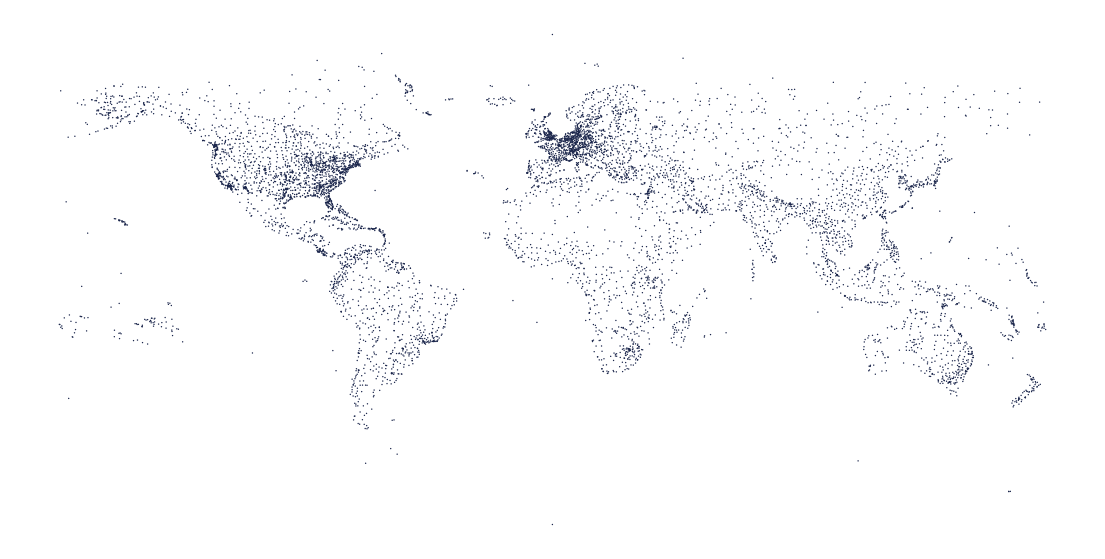

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)

ax.scatter(airports['long'], airports['lat'], s=1, alpha=1, facecolors="#1A254B", edgecolors='none')
ax.axis('off')

plt.savefig("../figures/usb_covid_airports_locations.svg")

plt.show()

In [6]:
country_mean_loc = airports[['country', 'lat', 'long']].groupby('country').agg('mean').applymap(np.deg2rad)
country_mean_loc

,lat,long
country,,
Afghanistan,0.594065,1.161830
Albania,0.721141,0.345964
Algeria,0.572921,0.053343
American Samoa,-0.249130,-2.968238
Angola,-0.188317,0.273806
...,...,...
West Bank,0.556144,0.614691
Western Sahara,0.451469,-0.237574
Yemen,0.260607,0.831397


In [7]:
delta_lat = country_mean_loc['lat'].to_numpy()
delta_lat = np.subtract.outer(delta_lat, delta_lat)

In [8]:
delta_long = country_mean_loc['long'].to_numpy()
delta_long = np.subtract.outer(delta_long, delta_long)

### Compute _geographic_ distance

In [9]:
# Compute geodesic distance on shpere (Haversine formula: sin^2(delta_lat/2) + cos(lat_1) * cos(lat_2) * sin^2(delta_long/2))
haversine = np.square(np.sin(delta_lat/2)) + np.expand_dims(np.cos(country_mean_loc['lat']), axis=1) * np.expand_dims(np.cos(country_mean_loc['lat']), axis=0) * np.square(np.sin(delta_long/2))

earth_radius = 6371
geo_dist = pd.DataFrame(2*earth_radius * np.arcsin(np.sqrt(haversine)), index=country_mean_loc.index, columns=country_mean_loc.index)

### Compute _flight_ distance

In [11]:
routes = pd.read_csv("flights/routes.csv", delimiter=',', names=['airline', 'id', 'source_airport', 'source_airport_id',
                                                               'destination_airport', 'destination_airport_id', 'codeshare',
                                                               'stops', 'equitment'])

In [12]:
source_airports = airports[['name', 'iata', 'icao', 'lat', 'long']]
destination_airports = source_airports.copy()
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

In [13]:
routes = routes[['source_airport', 'destination_airport']]
routes = pd.merge(routes, source_airports, left_on='source_airport', right_on='iata_source')
routes = pd.merge(routes, destination_airports, left_on='destination_airport', right_on='iata_destination')

print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


In [14]:
geometry = [LineString([[routes.iloc[i]['long_source'], routes.iloc[i]['lat_source']], [routes.iloc[i]['long_destination'], routes.iloc[i]['lat_destination']]]) for i in range(routes.shape[0])]
routes = gpd.GeoDataFrame(routes, geometry=geometry, crs='EPSG:4326')
routes

,source_airport,destination_airport,name_source,iata_source,icao_source,lat_source,long_source,name_destination,iata_destination,icao_destination,lat_destination,long_destination,geometry
0,AER,KZN,Sochi International Airport,AER,URSS,43.449902,39.956600,Kazan International Airport,KZN,UWKD,55.606201,49.278702,"LINESTRING (39.95660 43.44990, 49.27870 55.60620)"
1,ASF,KZN,Astrakhan Airport,ASF,URWA,46.283298,48.006302,Kazan International Airport,KZN,UWKD,55.606201,49.278702,"LINESTRING (48.00630 46.28330, 49.27870 55.60620)"
2,CEK,KZN,Chelyabinsk Balandino Airport,CEK,USCC,55.305801,61.503300,Kazan International Airport,KZN,UWKD,55.606201,49.278702,"LINESTRING (61.50330 55.30580, 49.27870 55.60620)"
3,DME,KZN,Domodedovo International Airport,DME,UUDD,55.408798,37.906300,Kazan International Airport,KZN,UWKD,55.606201,49.278702,"LINESTRING (37.90630 55.40880, 49.27870 55.60620)"
4,DME,KZN,Domodedovo International Airport,DME,UUDD,55.408798,37.906300,Kazan International Airport,KZN,UWKD,55.606201,49.278702,"LINESTRING (37.90630 55.40880, 49.27870 55.60620)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66929,ZKE,YFA,Kashechewan Airport,ZKE,CZKE,52.282501,-81.677803,Fort Albany Airport,YFA,CYFA,52.201401,-81.696899,"LINESTRING (-81.67780 52.28250, -81.69690 52.2..."
66930,YPO,YAT,Peawanuck Airport,YPO,CYPO,54.988098,-85.443298,Attawapiskat Airport,YAT,CYAT,52.927502,-82.431900,"LINESTRING (-85.44330 54.98810, -82.43190 52.9..."
66931,ZKE,YAT,Kashechewan Airport,ZKE,CZKE,52.282501,-81.677803,Attawapiskat Airport,YAT,CYAT,52.927502,-82.431900,"LINESTRING (-81.67780 52.28250, -82.43190 52.9..."
66932,JCK,RCM,Julia Creek Airport,JCK,YJLC,-20.668301,141.723007,Richmond Airport,RCM,YRMD,-20.701900,143.115005,"LINESTRING (141.72301 -20.66830, 143.11501 -20..."


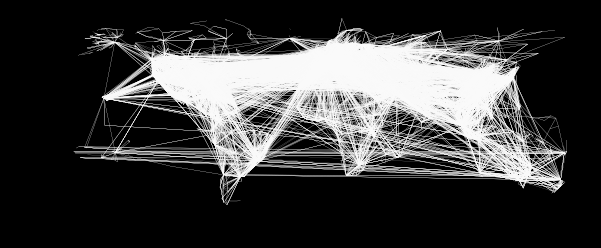

In [15]:
fig = plt.figure(facecolor='black')
ax = plt.axes()

fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('black')

routes.plot(ax=ax, color='white', linewidth=0.1)

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')

plt.show()

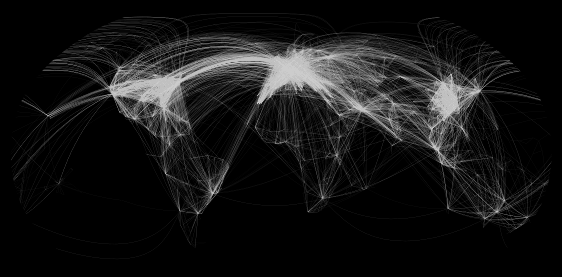

In [16]:
import cartopy.crs as ccrs

fig = plt.figure(facecolor='black')
ax = plt.axes(projection=ccrs.Robinson())
fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('black')

routes.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.1, alpha=0.1)

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 8800000)

plt.show()

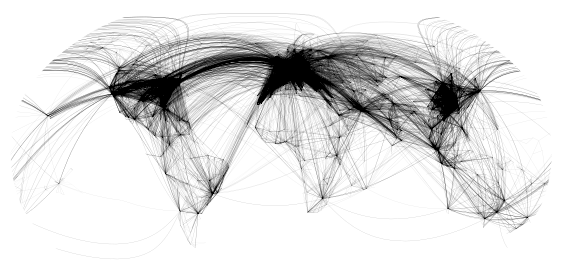

In [58]:
fig = plt.figure(facecolor='white')
ax = plt.axes(projection=ccrs.Robinson())
fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('white')

routes.plot(ax=ax, transform=ccrs.Geodetic(), color='black', linewidth=0.1, alpha=0.1)

plt.setp(ax.spines.values(), color='white')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')
ax.set_ylim(-7000000, 8800000)

plt.savefig("../figures/usb_covid_airport_connections.png", bbox_inches="tight", transparent=True)
plt.savefig("../figures/usb_covid_airport_connections.svg", bbox_inches="tight", transparent=True)

plt.show()

Derive distance between countries based on number of flight connections

In [15]:
airport_to_country = airports[['iata', 'country']].set_index('iata').to_dict()['country']
airport_to_country

{'GKA': 'Papua New Guinea',
 'MAG': 'Papua New Guinea',
 'HGU': 'Papua New Guinea',
 'LAE': 'Papua New Guinea',
 'POM': 'Papua New Guinea',
 'WWK': 'Papua New Guinea',
 'UAK': 'Greenland',
 'GOH': 'Greenland',
 'SFJ': 'Greenland',
 'THU': 'Greenland',
 'AEY': 'Iceland',
 'EGS': 'Iceland',
 'HFN': 'Iceland',
 'HZK': 'Iceland',
 'IFJ': 'Iceland',
 'KEF': 'Iceland',
 'PFJ': 'Iceland',
 'RKV': 'Iceland',
 'SIJ': 'Iceland',
 'VEY': 'Iceland',
 'YAM': 'Canada',
 '\\N': 'Ukraine',
 'YAY': 'Canada',
 'YAZ': 'Canada',
 'YBB': 'Canada',
 'YBC': 'Canada',
 'YBG': 'Canada',
 'YBK': 'Canada',
 'YBL': 'Canada',
 'YBR': 'Canada',
 'YCB': 'Canada',
 'YCD': 'Canada',
 'YCG': 'Canada',
 'YCH': 'Canada',
 'YCL': 'Canada',
 'YCO': 'Canada',
 'YCT': 'Canada',
 'YCW': 'Canada',
 'YCY': 'Canada',
 'YZS': 'Canada',
 'YDA': 'Canada',
 'YDB': 'Canada',
 'YDF': 'Canada',
 'YDL': 'Canada',
 'YDN': 'Canada',
 'YDQ': 'Canada',
 'YEG': 'Canada',
 'YEK': 'Canada',
 'YEN': 'Canada',
 'YET': 'Canada',
 'YEU': 'Canada',

In [16]:
country_routes = routes[['iata_source', 'iata_destination']].applymap(airport_to_country.get)
country_routes

,iata_source,iata_destination
0,Russia,Russia
1,Russia,Russia
2,Russia,Russia
3,Russia,Russia
4,Russia,Russia
...,...,...
66929,Canada,Canada
66930,Canada,Canada
66931,Canada,Canada
66932,Australia,Australia


In [17]:
country_routes.query("iata_source == 'Niue' or iata_destination == 'Nuie'")

,iata_source,iata_destination
53221,Niue,New Zealand


In [18]:
# Ignore routes to 'Niue', since no flight reaches this country and also remove 'Falkland Islands'
disconnected_countries = ['Niue','Falkland Islands']
country_routes = country_routes.query("iata_source not in @disconnected_countries and iata_destination not in @disconnected_countries")

In [19]:
print("Domestic flights:")
(country_routes['iata_source'] == country_routes['iata_destination']).mean()

Domestic flights:


0.4805994232866684

In [20]:
country_connection_strength = country_routes.reset_index(drop=False).rename(columns={'index': 'flights_num'}).groupby(['iata_source', 'iata_destination']).agg('count')
country_connection_strength

flights_num
iata_source iata_destination             
Afghanistan Afghanistan                14
            Azerbaijan                  1
            India                       7
            Iran                        5
            Kuwait                      1
...                                   ...
Zimbabwe    Namibia                     2
            South Africa                9
            Tanzania                    1
            Zambia                     11
            Zimbabwe                    6

[4693 rows x 1 columns]

In [21]:
country_connection_strength.loc['Australia', 'Australia']

flights_num    776
Name: (Australia, Australia), dtype: int64

In [22]:
connections_matrix = country_connection_strength.unstack(1).droplevel(0, axis=1)
connections_matrix

iata_destination,Afghanistan,Albania,Algeria,American Samoa,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uzbekistan,Vanuatu,Venezuela,Vietnam,Virgin Islands,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
iata_source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,NaN,NaN,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wallis and Futuna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
Western Sahara,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN


In [23]:
connections_matrix.loc['Italy', 'United Kingdom']

141.0

In [25]:
# Sanity check
# Origin/destination countries are the same (and in the same order)
assert (connections_matrix.index == connections_matrix.columns).all()

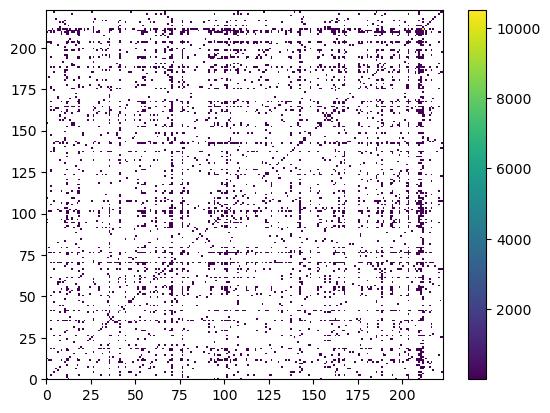

In [26]:
# plt.figure(figsize=(8, 8))
plt.pcolormesh(connections_matrix)
plt.colorbar();

Query the connection matrix

US $\rightarrow$ UK, UK $\rightarrow$ US

In [27]:
connections_matrix.loc["United States", "United Kingdom"], connections_matrix.loc["United Kingdom", "United States"]

(207.0, 203.0)

Italy $\rightarrow$ France

In [28]:
connections_matrix.loc["Italy", "France"], connections_matrix.loc["Italy"].sum(), connections_matrix.loc["Italy", "France"] / connections_matrix.loc["Italy"].sum()

(148.0, 1776.0, 0.08333333333333333)

Italy $\rightarrow$ UK

In [29]:
connections_matrix.loc["Italy", "United Kingdom"], connections_matrix.loc["United Kingdom"].sum(), connections_matrix.loc["Italy", "United Kingdom"] / connections_matrix.loc["United Kingdom"].sum()

(141.0, 2663.0, 0.05294780322944048)

Italy $\rightarrow$ US

In [30]:
connections_matrix.loc["United Kingdom", "France"], connections_matrix.loc["France"].sum(), connections_matrix.loc["United Kingdom", "France"] / connections_matrix.loc["France"].sum()

(158.0, 1926.0, 0.08203530633437175)

In [31]:
# Symmetrize matrix

distance_matrix = connections_matrix.copy() #.applymap(np.log)

# Enforce reflexivity property of distance
distance_matrix = (1-np.eye(distance_matrix.shape[0])) * distance_matrix

# Symmetrize matrix
distance_matrix = (distance_matrix + distance_matrix.T) / 2

# Normalize matrix
distance_matrix_out = distance_matrix.sum(axis=0) - distance_matrix
distance_matrix_in = (distance_matrix.sum(axis=1) - distance_matrix.T).T

# Symmetrize matrix (after normalizing by outgoing flow)
distance_matrix = 2/(distance_matrix_in + distance_matrix_out + 2)

# # Normalize matrix
# distance_matrix = distance_matrix.max() - distance_matrix + 1

# Enforce (again) reflexivity property of distance
distance_matrix = (1-np.eye(distance_matrix.shape[0])) * distance_matrix

# Symmetrize matrix
distance_matrix = (distance_matrix + distance_matrix.T) / 2

distance_matrix

iata_destination,Afghanistan,Albania,Algeria,American Samoa,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uzbekistan,Vanuatu,Venezuela,Vietnam,Virgin Islands,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
iata_source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wallis and Futuna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
Western Sahara,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


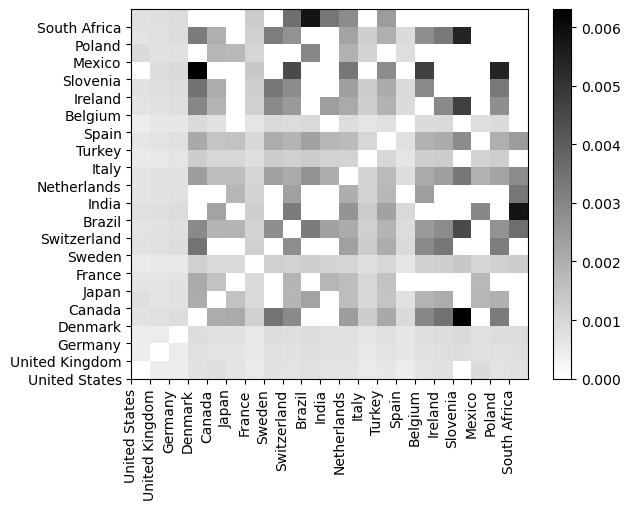

In [38]:
selected_countries = ["United States", "United Kingdom", "Germany", "Denmark", "Canada", "Japan", "France", "Sweden", "Switzerland", "Brazil", "India", "Netherlands", "Italy", "Turkey", "Spain", "Belgium", "Ireland", "Slovenia", "Mexico", "Poland", "South Africa"]
plt.pcolormesh(distance_matrix.loc[selected_countries,selected_countries], cmap="gist_yarg")
plt.xticks(range(distance_matrix.loc[selected_countries,selected_countries].shape[0]), selected_countries, rotation=90)
plt.yticks(range(distance_matrix.loc[selected_countries,selected_countries].shape[1]), selected_countries);
plt.colorbar()

plt.savefig("../figures/usb_covid_country_route_dist.svg", bbox_inches="tight", transparent=True)

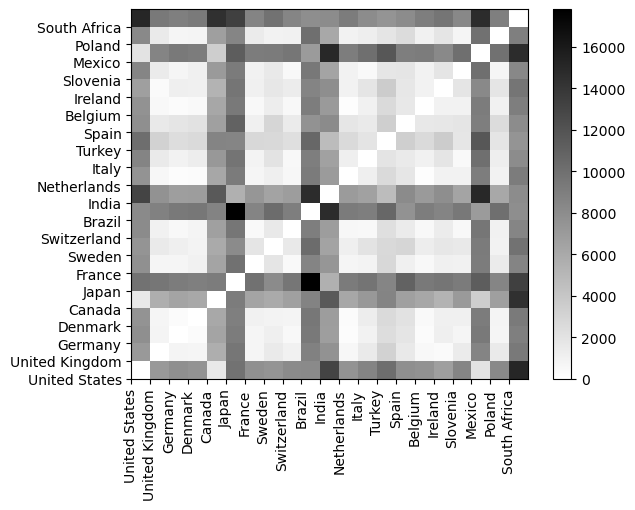

In [40]:
plt.pcolormesh(geo_dist.loc[selected_countries,selected_countries], cmap="gist_yarg")
plt.xticks(range(geo_dist.loc[selected_countries,selected_countries].shape[0]), selected_countries, rotation=90)
plt.yticks(range(geo_dist.loc[selected_countries,selected_countries].shape[1]), selected_countries);
plt.colorbar()

plt.savefig("../figures/usb_covid_country_geo_dist.svg", bbox_inches="tight", transparent=True)

### Compute _effective_ distance

In [36]:
# Multiply virtual distance (given by connection strength) by geographic distance between countries
effective_distance_matrix = distance_matrix * geo_dist.loc[distance_matrix.index, distance_matrix.columns]

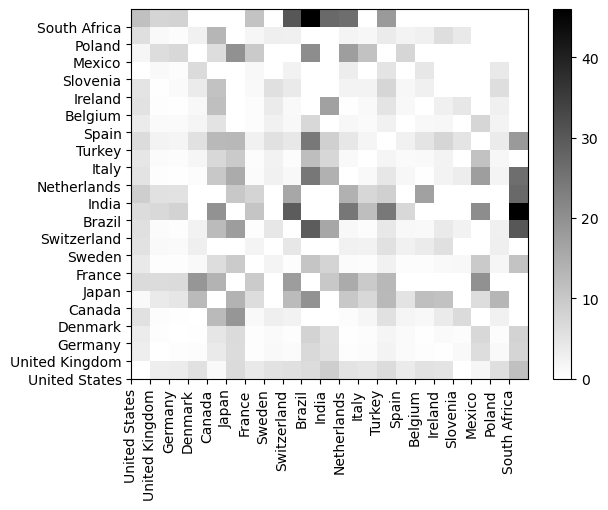

In [44]:
plt.pcolormesh(effective_distance_matrix.loc[selected_countries,selected_countries], cmap="gist_yarg")
plt.xticks(range(effective_distance_matrix.loc[selected_countries,selected_countries].shape[0]), selected_countries, rotation=90)
plt.yticks(range(effective_distance_matrix.loc[selected_countries,selected_countries].shape[1]), selected_countries);
plt.colorbar()

plt.savefig("../figures/usb_covid_country_effective_dist.svg", bbox_inches="tight", transparent=True)

In [113]:
effective_distance_matrix.loc["Italy", "France"], effective_distance_matrix.loc["Italy", "United Kingdom"], effective_distance_matrix.loc["United Kingdom", "France"]

(0.7019624389933287, 0.8841631563761857, 0.4277017818188758)

In [114]:
effective_distance_matrix.loc["United Kingdom", "United States"], effective_distance_matrix.loc["United States", "United Kingdom"]

(3.206591865631413, 3.206591865631413)

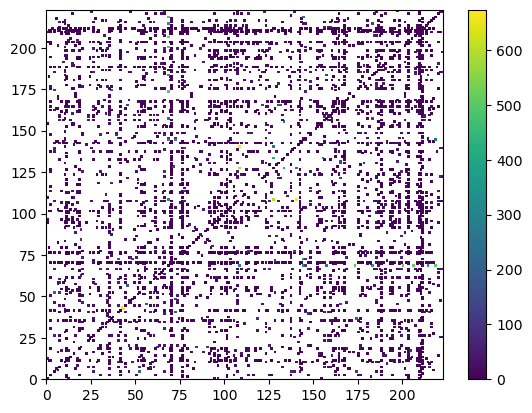

In [115]:
plt.pcolormesh(effective_distance_matrix)
plt.colorbar()

### Extract shortest paths

In [116]:
import scipy as sp

In [117]:
shortest_paths = sp.sparse.csgraph.shortest_path(np.array(effective_distance_matrix.fillna(0)))
shortest_paths

array([[ 0.        , 10.08851045, 10.42377426, ...,  8.80884026,
        18.72300805, 30.20659194],
       [10.08851045,  0.        ,  2.86059965, ...,  7.3901975 ,
        17.3043653 , 22.74931494],
       [10.42377426,  2.86059965,  0.        , ...,  7.72546131,
        17.6396291 , 22.89198371],
       ...,
       [ 8.80884026,  7.3901975 ,  7.72546131, ...,  0.        ,
        16.0246951 , 27.50827899],
       [18.72300805, 17.3043653 , 17.6396291 , ..., 16.0246951 ,
         0.        , 37.42244678],
       [30.20659194, 22.74931494, 22.89198371, ..., 27.50827899,
        37.42244678,  0.        ]])

Closest destinations reachable from...

**UK**

In [119]:
effective_distance_matrix.index[np.argsort(shortest_paths[np.where(effective_distance_matrix.index == "United Kingdom")[0][0]])][:10]

Index(['United Kingdom', 'Isle of Man', 'Guernsey', 'Jersey', 'Ireland',
       'Germany', 'Belgium', 'Netherlands', 'France', 'Denmark'],
      dtype='object', name='iata_source')

**US**

In [120]:
effective_distance_matrix.index[np.argsort(shortest_paths[np.where(effective_distance_matrix.index == "United States")[0][0]])][:10]

Index(['United States', 'Belize', 'Canada', 'Mexico', 'Guatemala', 'Bahamas',
       'Cayman Islands', 'Honduras', 'El Salvador', 'Jamaica'],
      dtype='object', name='iata_source')

**Italy**

In [121]:
effective_distance_matrix.index[np.argsort(shortest_paths[np.where(effective_distance_matrix.index == "Italy")[0][0]])][:10]

Index(['Italy', 'Croatia', 'Germany', 'Switzerland', 'Austria', 'France',
       'Bosnia and Herzegovina', 'Netherlands', 'Luxembourg', 'Belgium'],
      dtype='object', name='iata_source')

**Mexico**

In [122]:
effective_distance_matrix.index[np.argsort(shortest_paths[np.where(effective_distance_matrix.index == "Mexico")[0][0]])][:10]

Index(['Mexico', 'United States', 'Belize', 'Canada', 'Guatemala', 'Bahamas',
       'Cayman Islands', 'Honduras', 'El Salvador', 'Jamaica'],
      dtype='object', name='iata_source')

### Rescale _effective_ distance

In [125]:
# Sanity check
# The graph does not have disconnected components
assert len(list(zip(effective_distance_matrix.index[np.where(np.isinf(shortest_paths))[0]], effective_distance_matrix.index[np.where(np.isinf(shortest_paths))[1]]))) == 0

In [126]:
# Normalize path lengths
shortest_paths = shortest_paths / shortest_paths.max() * 200

In [127]:
shortest_paths.max()

200.0

### Embed _effective_ distance in the plane

**NOTE**: Each time the following code is run, it produces a _new_ version of (stochastic) embeddings

In [128]:
import sklearn.manifold as manifold
from umap import UMAP

In [246]:
tsne = UMAP(n_neighbors=200, metric="precomputed")

In [247]:
dist_embeddings = tsne.fit_transform(shortest_paths.copy())

/home/ubuntu/anaconda3/envs/dsb/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [248]:
# version_counter = 48
prev_versions = pd.Series(os.listdir("flights/"))
prev_versions = prev_versions[prev_versions.str.contains("distance_embeddings")].apply(lambda x: int(x.split("_")[-1].split(".")[0]))

version_counter = prev_versions.max()

In [249]:
version_counter

58

In [250]:
raw_dist_embeddings = dist_embeddings.copy()

In [251]:
dist_embeddings = raw_dist_embeddings - raw_dist_embeddings.mean(axis=0)
dist_embeddings = dist_embeddings +  np.sign(dist_embeddings) * np.clip(.1 * (1. - 1.0/(1.0 + np.exp(-dist_embeddings))), 0., None)

In [253]:
version_counter += 1
np.savez(f"flights/country_distance_embeddings_{version_counter}.npz", countries=effective_distance_matrix.index.to_numpy(), embeddings=dist_embeddings)
version_counter

59

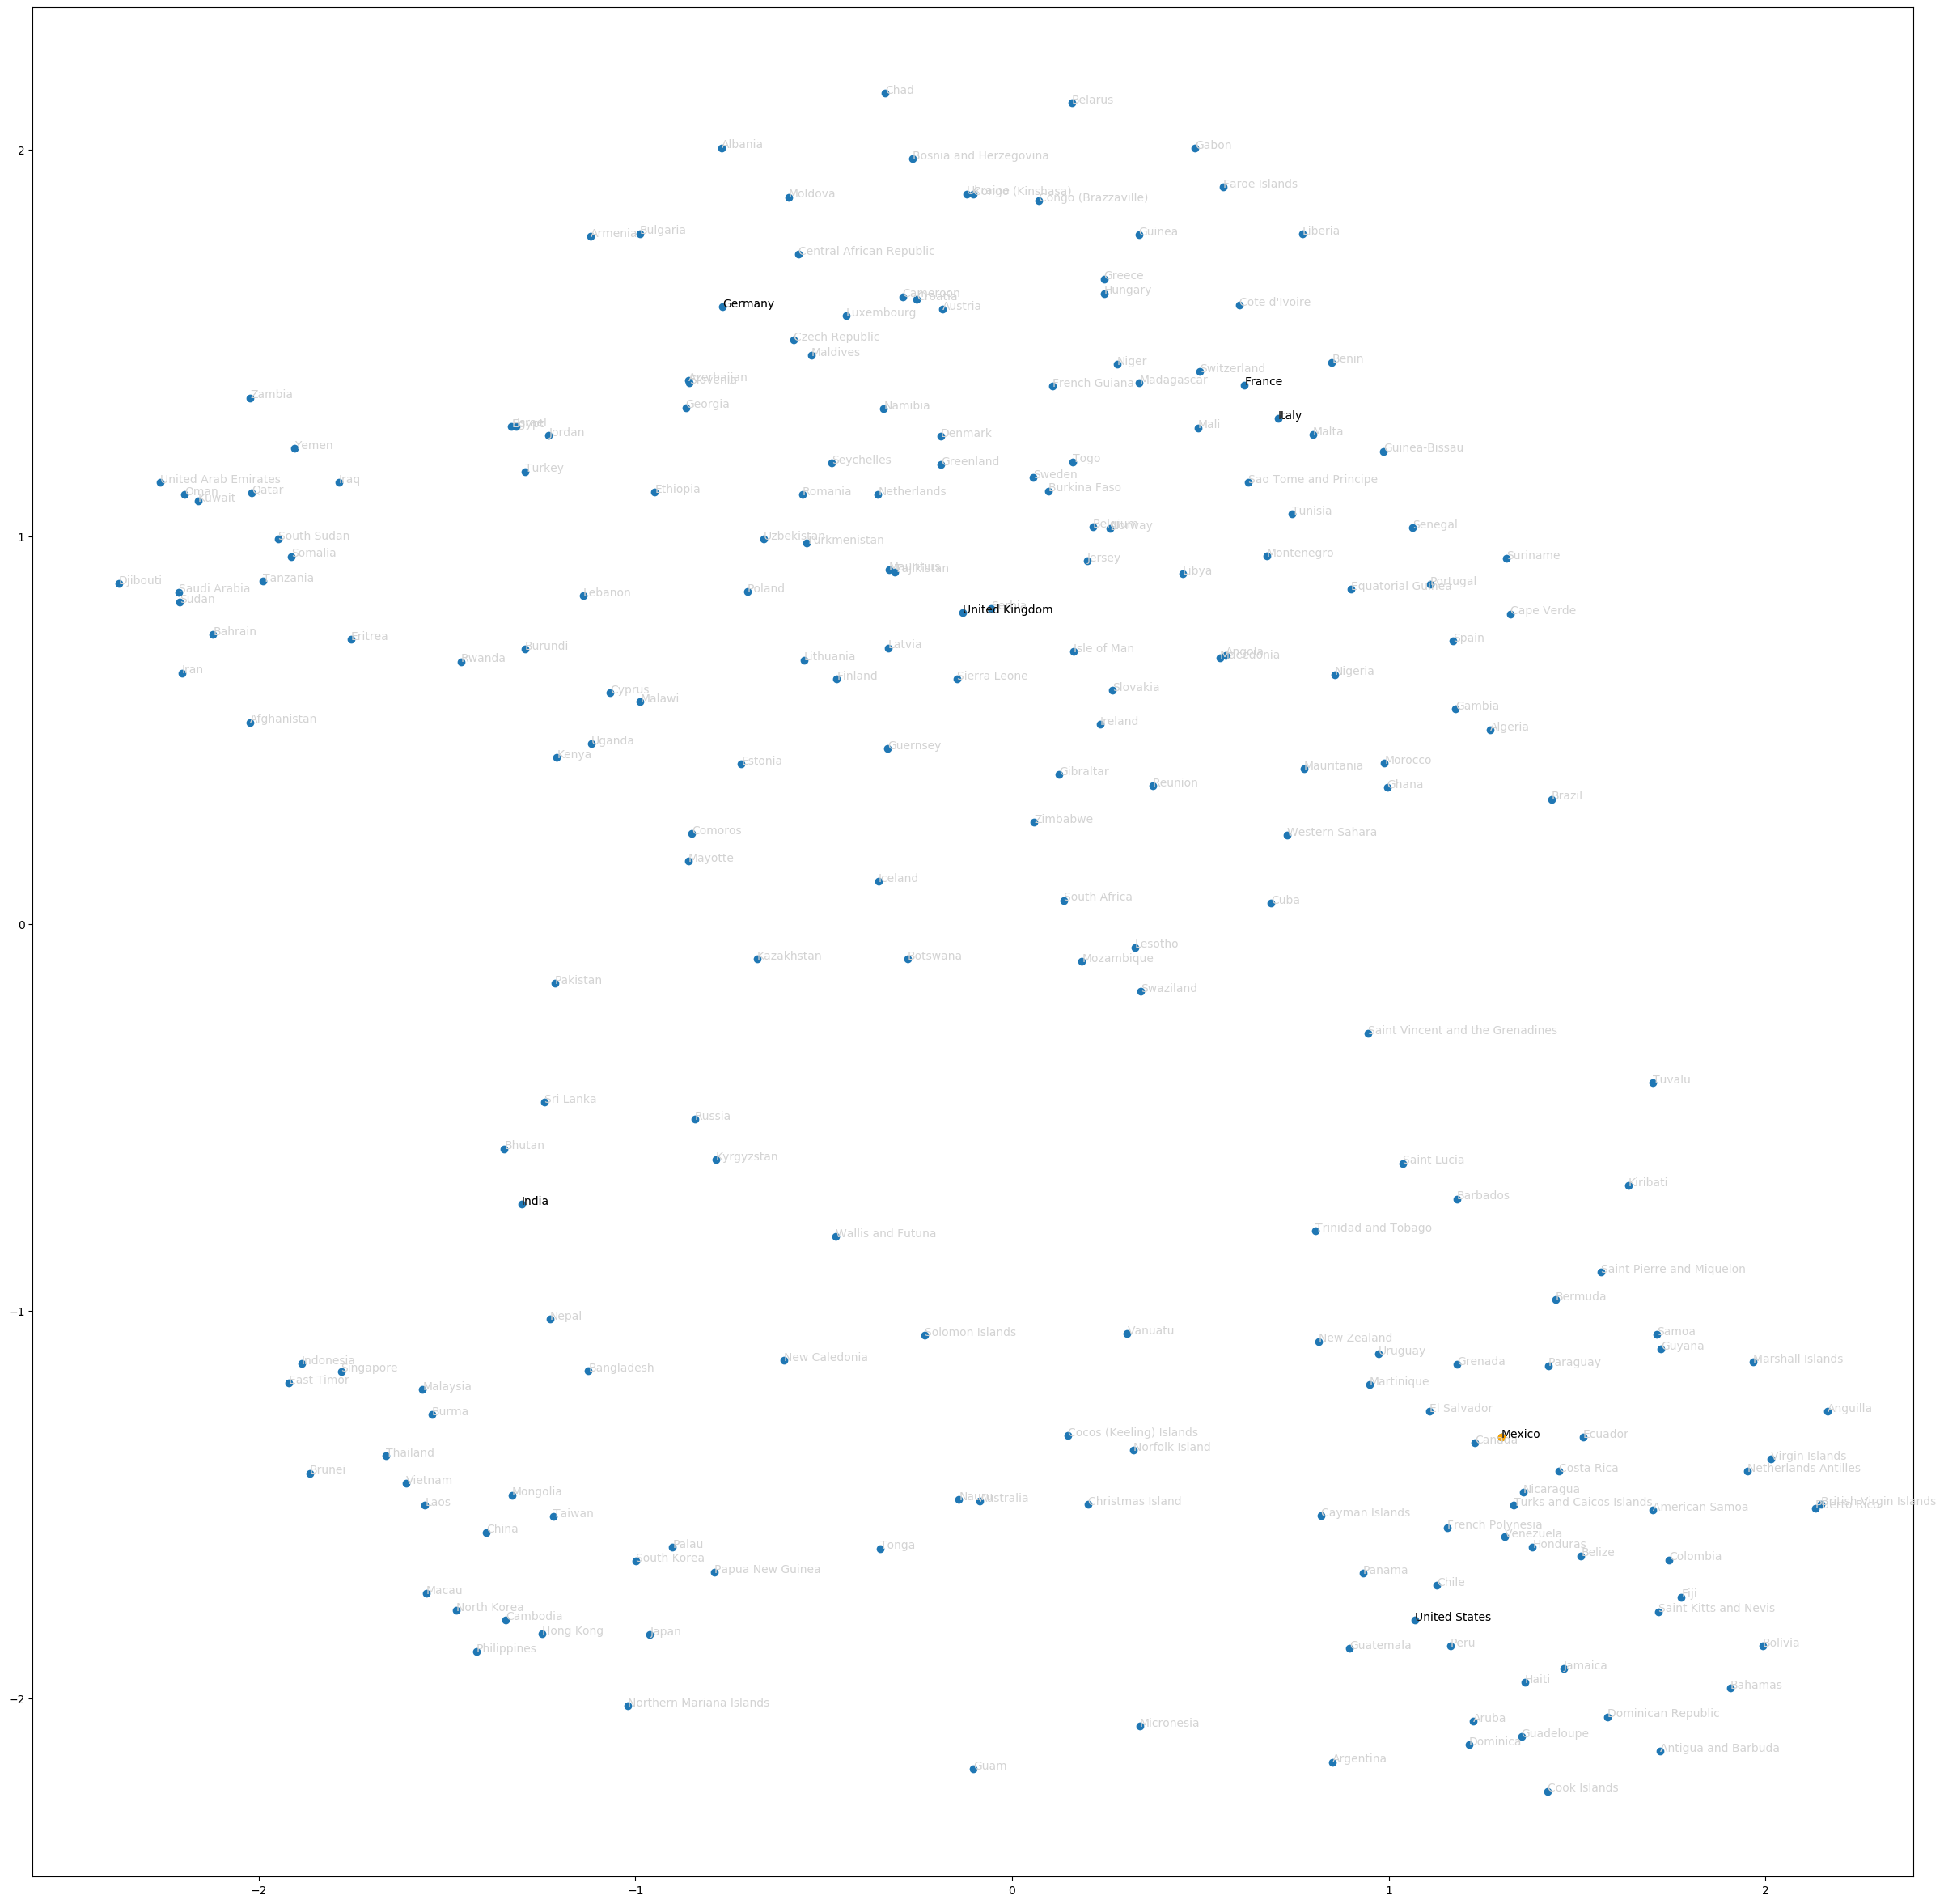

In [254]:
plt.figure(figsize=(30, 30))
plt.scatter(*dist_embeddings.T)
for idx, c in enumerate(effective_distance_matrix.index):
    plt.annotate(c, dist_embeddings[idx], color='lightgray')
    if c in ["United States", "Mexico", "Italy", "Germany", "France", "United Kingdom", "India"]:
        plt.annotate(c, dist_embeddings[idx])
    if c == "Mexico":
        plt.scatter(*dist_embeddings[idx], color="orange")

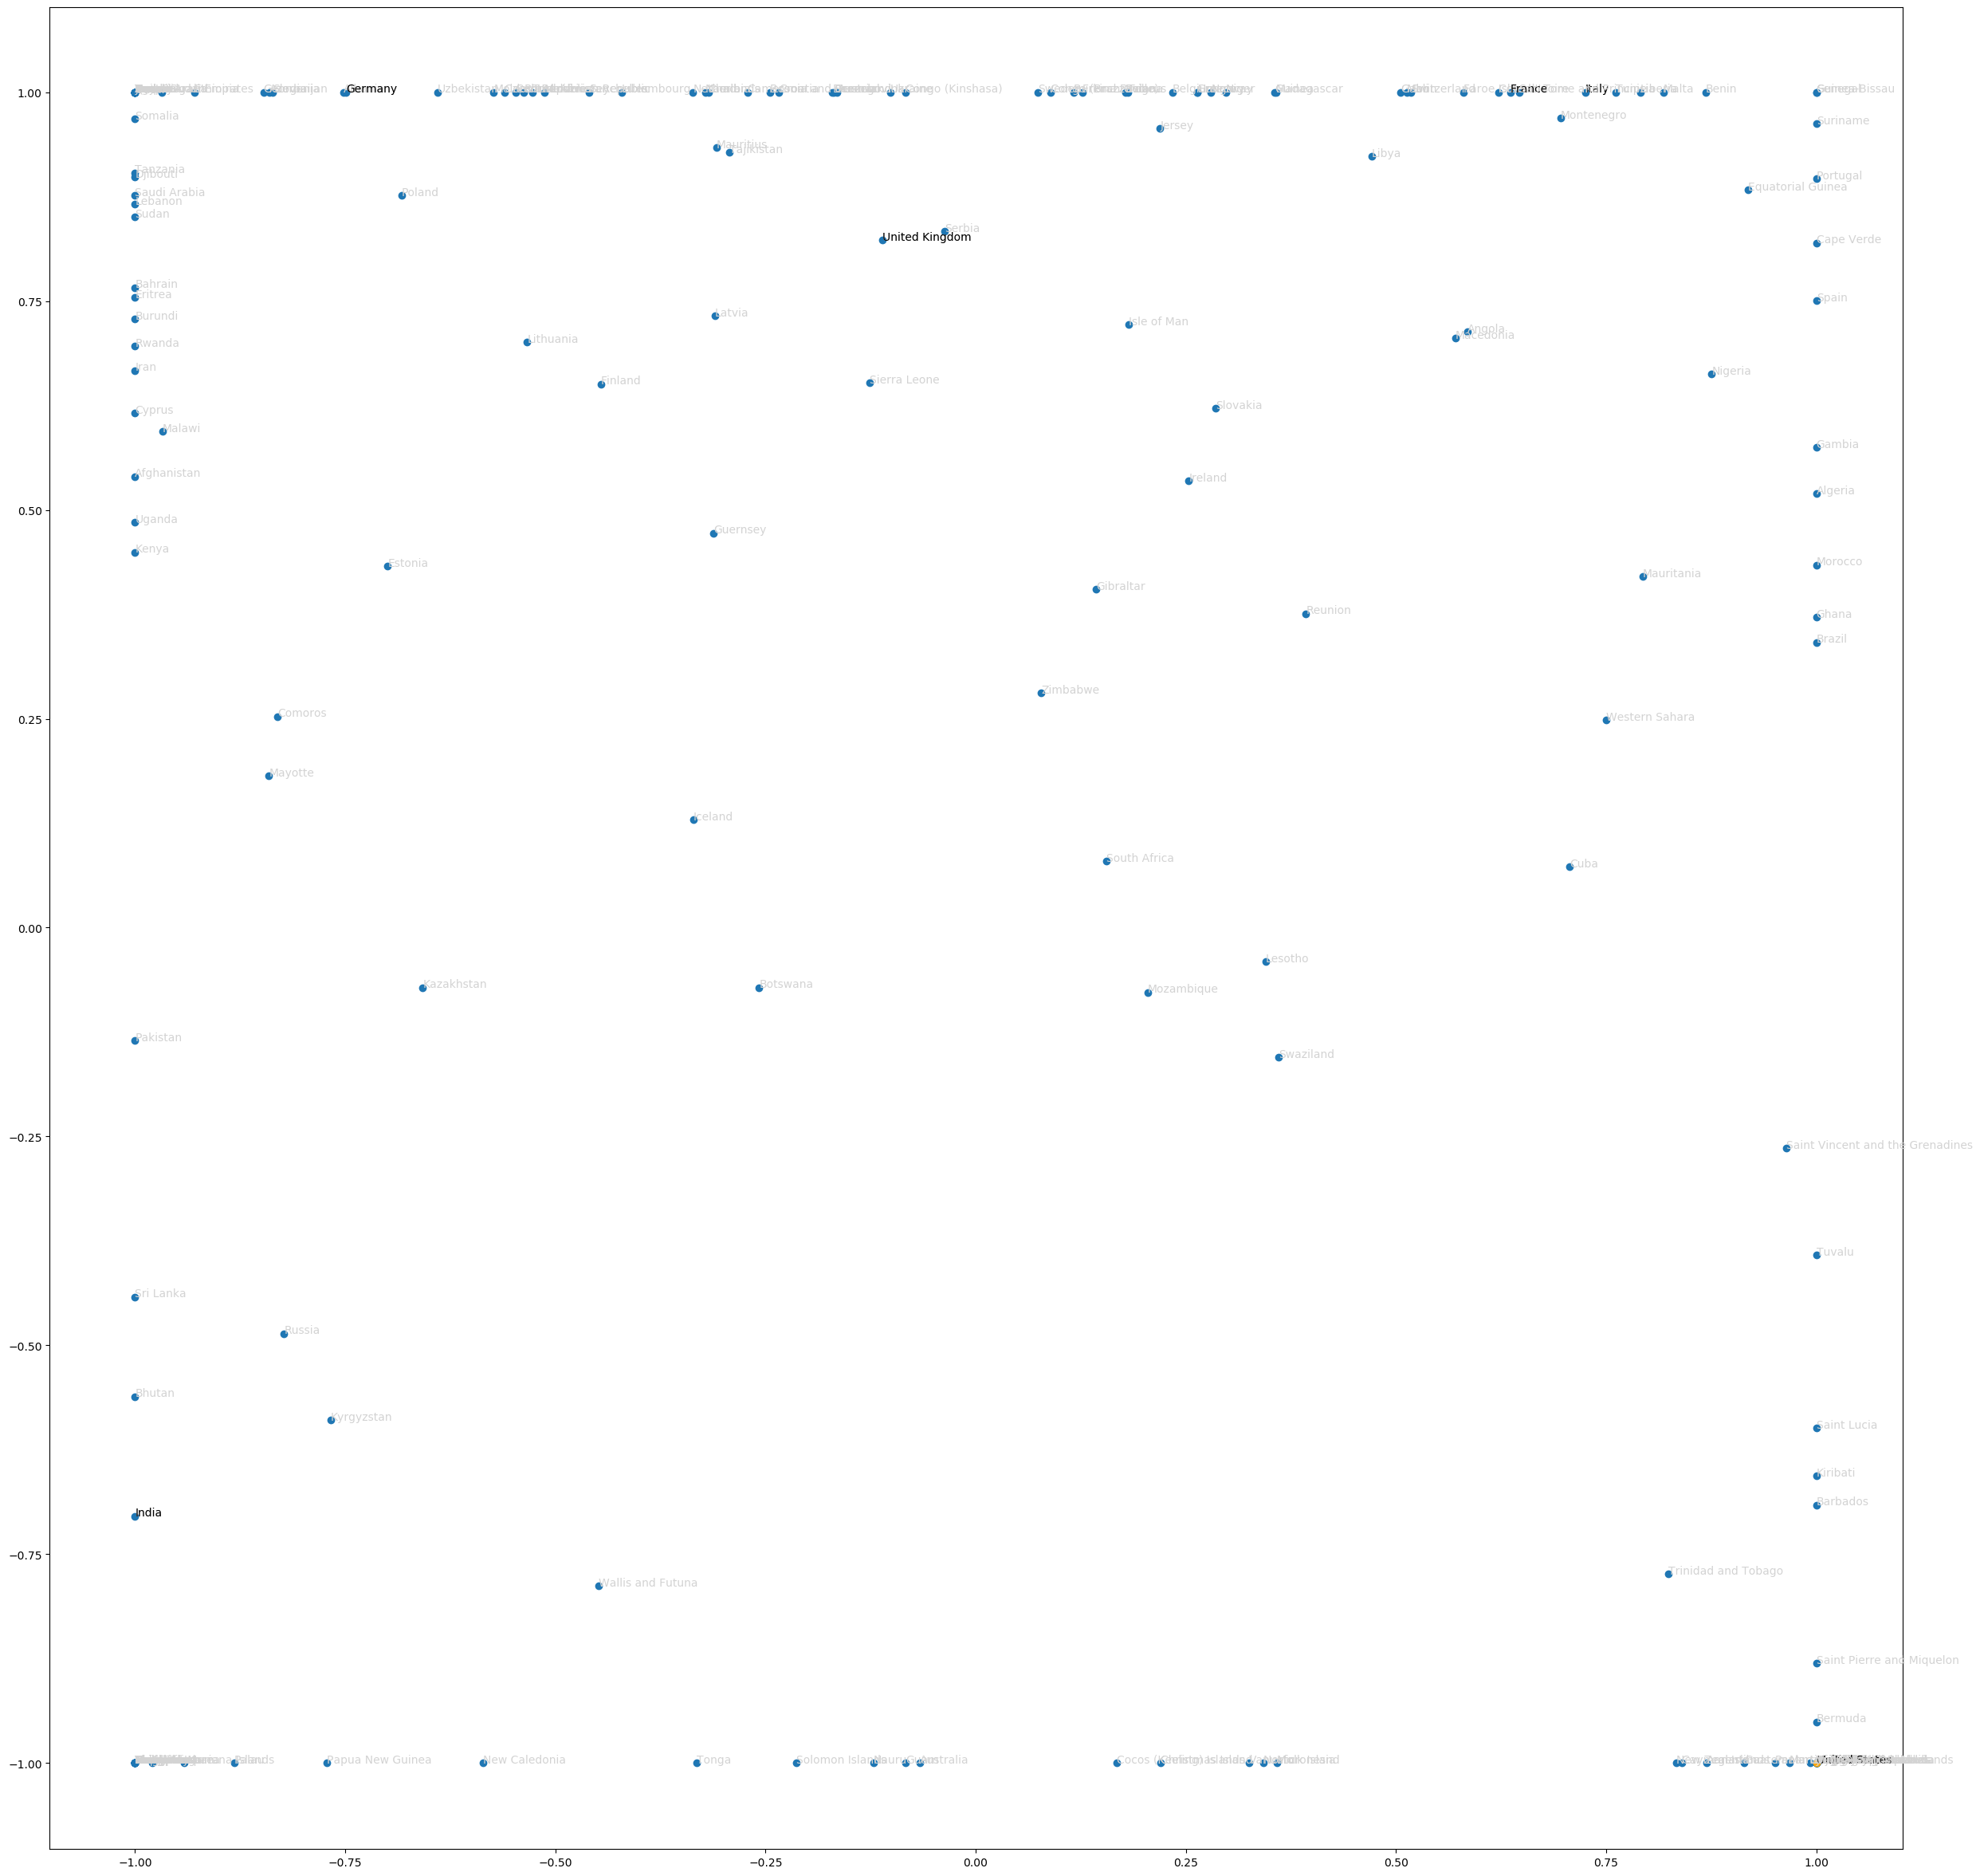

In [257]:
plt.figure(figsize=(30, 30))
centered_dist_embeddings = np.clip(dist_embeddings - dist_embeddings.mean(axis=0, keepdims=True), -1., 1.)
plt.scatter(*centered_dist_embeddings.T)
for idx, c in enumerate(effective_distance_matrix.index):
    plt.annotate(c, centered_dist_embeddings[idx], color='lightgray')
    if c in ["United States", "Mexico", "Italy", "Germany", "France", "United Kingdom", "India"]:
        plt.annotate(c, centered_dist_embeddings[idx])
    if c == "Mexico":
        plt.scatter(*centered_dist_embeddings[idx], color="orange")